In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('always')

import anndata
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scanpy as sc
import torch
from torch.autograd import Variable

from scbasset.utils import *
import scbasset.metrics as metrics
from scbasset.model_class import ModelClass
from scbasset.config import Config

In [3]:
start_directory = '../../../'
# start_directory = ''

seq_len = 768
type_data = 'TF_to_region'
file_name = 'TF_to_region_hvg'
# file_name = 'TF_to_region_ctx'
# file_name = 'TF_to_region_scplus'

data_path = start_directory + 'data/' + type_data + '/processed/'

ad_file = data_path + file_name + '-' + str(seq_len) + '-ad.h5ad'
h5_file = data_path + file_name + '-' + str(seq_len) + '-train_val_test.h5'

In [4]:
f = h5py.File(h5_file, 'r')
X = f['X'][:].astype('float32')
Y = f['Y'][:].astype('float32')

# Split train-validation set
train_ids, val_ids, test_ids = f['train_ids'][:], f['val_ids'][:], f['test_ids'][:]

X = torch.FloatTensor(X)

n_TFs = Y.shape[1]
ic(n_TFs, Y.shape[0])

ic| n_TFs: 945, Y.shape[0]: 12835


(945, 12835)

In [5]:
ad = anndata.read_h5ad(ad_file)
ad

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 945 × 12835
    obs: 'TF', 'exp_id', 'cell_line', 'motif_model', 'n_genes'
    var: 'chr', 'start', 'end', 'n_cells'

In [6]:
# os.makedirs("../..", exist_ok=True)
print(torch.cuda.is_available())
device = "cuda"
if "cuda" in device and not torch.cuda.is_available():
    device = "cpu"
else:
    torch.cuda.set_device(1)

print(device)

True
cuda


In [155]:
config = Config()
config.h5_file = h5_file
config.bottleneck_size = 64
config.activation_fct = 'gelu'
config.batch_size = 64
# config.model_name = 'scbasset'
config.model_name = 'tfbanformer'
config.num_heads = 8
config.num_transforms = 7
config.repeat = 4
config.tower_multiplier = 1.222

print(config)

# load model
dashboard_model = ModelClass(config, n_TFs=n_TFs)
dashboard_model.activate_analysis()
dashboard_model.load_data(h5_file, shuffle=False)
# dashboard_model.load_weights(device, best=0, trained_model_dir='output/scbasset/TF_to_region_hvg/32_1344_6_TL/')
dashboard_model.load_weights(device, best=0, start_directory=start_directory)
dashboard_model.get_model_summary()
model = dashboard_model.model
model.to(device)

Config(parser_args=None, out_dir='output', bottleneck=32, batch_size=64, learning_rate=0.01, epochs=1000, h5_file='../../../data/TF_to_region/processed/TF_to_region_hvg-768-train_val_test.h5', model_name='tfbanformer', residual_model=False, activation_fct='gelu', seq_length=1344, num_heads=8, repeat=4, num_transforms=7, cuda=2, logs='logs', weights=None, tower_multiplier=1.222)


ic| self.n_TFs: 945, len(X_train): 11552, len(Y_train): 11552
ic| features.shape: torch.Size([64, 768, 4])
ic| trained_model_dir: 'output/tfbanformer/TF_to_region_hvg/64_768_4_8_7_64_gelu_1-222/'


TfBanformer(
  (conv_block1): ConvBlock(
    (nonLinear): GELU()
    (bn_layer): BatchNorm1d(288, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (conv_layer): Conv1d(4, 288, kernel_size=(17,), stride=(1,), padding=same, bias=False)
    (maxpool_layer): MaxPool1d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_tower1): ConvTower(
    (conv_blocks): ModuleList(
      (0): ConvBlock(
        (nonLinear): GELU()
        (bn_layer): BatchNorm1d(288, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (conv_layer): Conv1d(288, 288, kernel_size=(5,), stride=(1,), padding=same, bias=False)
        (maxpool_layer): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvBlock(
        (nonLinear): GELU()
        (bn_layer): BatchNorm1d(352, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (conv_layer): Conv1d(288, 352, kernel_size=(5,), stride=(1,), padding=same

In [156]:
df_score, df_y = dashboard_model.predict_batch(dashboard_model.train_dataloader, sigmoid=True)

100%|███████████████████████████████████████████████████████████████████████████| 181/181 [00:06<00:00, 28.13batch/s]


In [157]:
fpr, tpr, fnr, opt_threshold, threshold, roc_auc, result_roc = metrics.roc_curve_multilabel(df_score, df_y)
print(opt_threshold['micro'])

sum = 0
for key in opt_threshold.keys():
    if key != 'micro':
        sum += opt_threshold[key]
sum / (len(opt_threshold.keys()) - 1)

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



0.07194348


0.19807161788629374

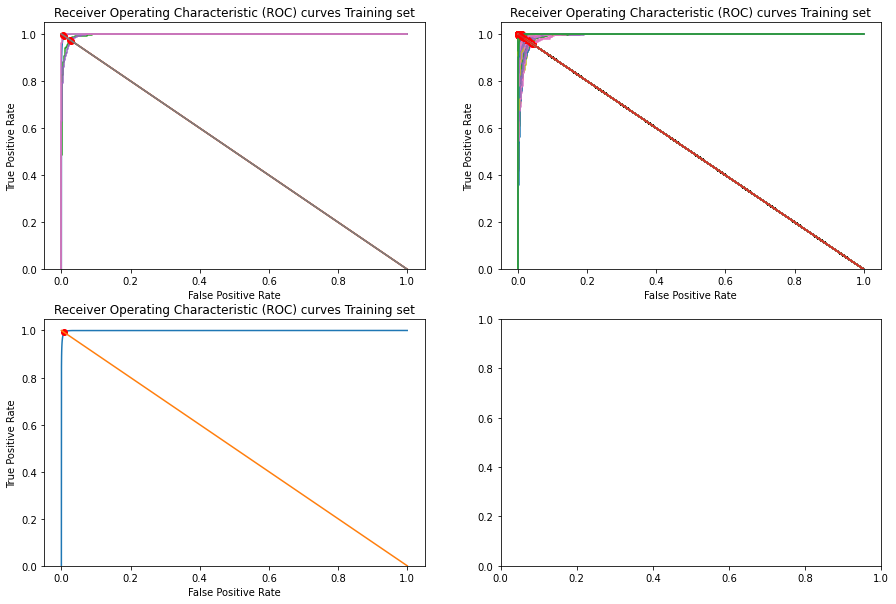

In [158]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_eer_roc(fpr['micro'], tpr['micro'], axes[0][0], result_roc['micro'], "Training set")
metrics.plot_eer_roc(fpr['micro'], tpr['micro'], axes[1][0], result_roc['micro'], "Training set")
metrics.plot_eer_roc(fpr[0], tpr[0], axes[0][0], result_roc[0], "Training set")
metrics.plot_eer_roc(fpr[1], tpr[1], axes[0][0], result_roc[1], "Training set")
metrics.plot_eer_roc(fpr[2], tpr[2], axes[0][0], result_roc[2], "Training set")
for key in result_roc.keys():
    metrics.plot_eer_roc(fpr[key], tpr[key], axes[0][1], result_roc[key], "Training set")

In [159]:
df_total_scores = dashboard_model.contruct_auc_scores_by_TF(df_y, df_score, ad)
df_total_scores

auc_roc    auc_pr  count_regions       TF motif_model  \
0    0.996828  0.916193            281    FOXK2    MA1103.2   
1    0.996448  0.955031            684    GATA3    MA0037.3   
2    0.999916  0.998613            645     CTCF    MA0139.1   
3    0.999984  0.999780            775     CTCF    MA0139.1   
4    0.999884  0.998676            863     CTCF    MA0139.1   
..        ...       ...            ...      ...         ...   
940  0.999997  0.999706            131      FOS    MA1134.1   
941  0.997725  0.970148            611     TCF4    MA0830.2   
942  0.998703  0.964219            237      YY1    MA0095.2   
943  0.999509  0.985238            309  BHLHE22    MA0818.1   
944  0.999314  0.919035             70      MYC    MA0147.3   

                                           cell_line  
0                          K562_myelogenous_leukemia  
1                                     Jurkat_T-cells  
2                                        CD4_T-cells  
3      ID00014_lymphoblastoid_cell_DiGeorge_syndrome  
4                                            gm10847  
..                                               ...  
940                   THP-1_acute_monocytic_leukemia  
941            CAL-1_plasmacytoid_dendritic_neoplasm  
942  GM12892_female_B-cells_lymphoblastoid_cell_line  
943            CAL-1_plasmacytoid_dendritic_neoplasm  
944                        MM1_S_plasma_cell_myeloma  

[945 rows x 6 columns]

In [160]:
print('auc roc score : ', df_total_scores['auc_roc'].mean())
print('auc pr score : ', df_total_scores['auc_pr'].mean())

auc roc score :  0.9950844055169765
auc pr score :  0.9755075048411652


In [161]:
f = h5py.File(h5_file, 'r')

# Split train-validation set
train_ids, val_ids, test_ids = f['train_ids'][:], f['val_ids'][:], f['test_ids'][:]

In [162]:
def contruct_auc_scores_by_region(df_y, df_pred: pd.DataFrame, ids, adata=None):
    auc_roc_l, auc_pr_l = [], []
    for row in range(len(df_pred)):   
        y_true = df_y.loc[row].values
        y_score = df_pred.loc[row].values

        auc_roc, auc_pr = dashboard_model.compute_metrics(y_true, y_score, all=False)

        auc_roc_l.append(auc_roc)
        auc_pr_l.append(auc_pr)

    df_total_score = pd.DataFrame(columns=['auc_roc', 'auc_pr'])
    df_total_score['auc_roc'] = auc_roc_l
    df_total_score['auc_pr'] = auc_pr_l
    
    if adata is not None: 
        ad_T = ad.T
        ad_T = ad_T.obs.reset_index()
        ad_T = ad_T.iloc[ids]
        # adata_test
        
        df_total_score['region'] = ad_T.iloc[:]['index']
        df_total_score['count_TFs'] = ad_T.iloc[:]['n_cells']
    return df_total_score

In [163]:
df_total_scores_region = contruct_auc_scores_by_region(df_y, df_score, train_ids, ad)
df_total_scores_region

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


auc_roc    auc_pr                   region  count_TFs
0      1.000000  1.000000                      NaN        NaN
1      0.988307  0.942588  chr17:69246562-69247062      149.0
2      0.000000  0.000000  chr17:69327043-69327543      143.0
3      0.999369  0.997208  chr17:69328111-69328611        0.0
4      0.998912  0.996457  chr17:69335014-69335514      162.0
...         ...       ...                      ...        ...
11547  0.999951  0.998024  chr17:75482884-75483384        0.0
11548  1.000000  1.000000  chr17:75477375-75477875        1.0
11549  0.993136  0.950469                      NaN        NaN
11550  0.999991  0.999940  chr17:75490949-75491449        9.0
11551  1.000000  1.000000    chr20:8006519-8007019        0.0

[11552 rows x 4 columns]

In [164]:
print('auc roc score : ', df_total_scores['auc_roc'].mean())
print('auc pr score : ', df_total_scores['auc_pr'].mean())

auc roc score :  0.9950844055169765
auc pr score :  0.9755075048411652


In [165]:
import plotly.express as px
fig = px.scatter(df_total_scores, x="auc_roc", y="auc_pr", hover_data=['TF', 'cell_line', 'motif_model', 'count_regions'], 
                 color="TF", marginal_x="rug", marginal_y="rug")
fig.show()

In [166]:
selection = ['CTCF', 'SPI1', 'MYC', 'RUNX1', 'RXRA', 'YY1', 'RELA', 'FOS', 'CEBPA', 'CEBPB', 'JUN', 'GATA2', 'JUND', 'REST', 'GATA3', 'TP53', 'MAX', 'GABPA', 'PAX5', 'EBF1']

df1 = df_total_scores[df_total_scores.TF.apply(lambda x: np.any(np.in1d(x, selection)))]
df1.TF.cat.remove_unused_categories(inplace=True)
df1.TF.head(5)

/local_scratch/tmp-vsc34619/ipykernel_5040/3815598737.py:4: FutureWarning:

The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.



1    GATA3
2     CTCF
3     CTCF
4     CTCF
5     CTCF
Name: TF, dtype: category
Categories (15, object): ['CTCF', 'E2F1', 'FOS', 'FOSL1', ..., 'RXRA', 'SPI1', 'SPIB', 'YY1']

In [167]:
colorscales = px.colors.cyclical.swatches_continuous()
fig = px.scatter(df1, x="auc_roc", y="auc_pr", hover_data=['TF', 'cell_line', 'motif_model', 'count_regions'], 
                 color="TF", marginal_x="rug", marginal_y="rug", color_discrete_sequence=px.colors.qualitative.Dark24)
fig.show()

validation and test

In [168]:
df_val_score, df_val_y = dashboard_model.predict_batch(dashboard_model.val_dataloader, sigmoid=True)
fpr, tpr, fnr, opt_threshold, threshold, roc_auc, result_roc = metrics.roc_curve_multilabel(df_val_score, df_val_y)
print(opt_threshold['micro'])

sum = 0
for key in opt_threshold.keys():
    if key != 'micro':
        sum += opt_threshold[key]
sum / (len(opt_threshold.keys()) - 1)

100%|█████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.16batch/s]
/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples 

5.2499696e-11


0.0011727232157135955

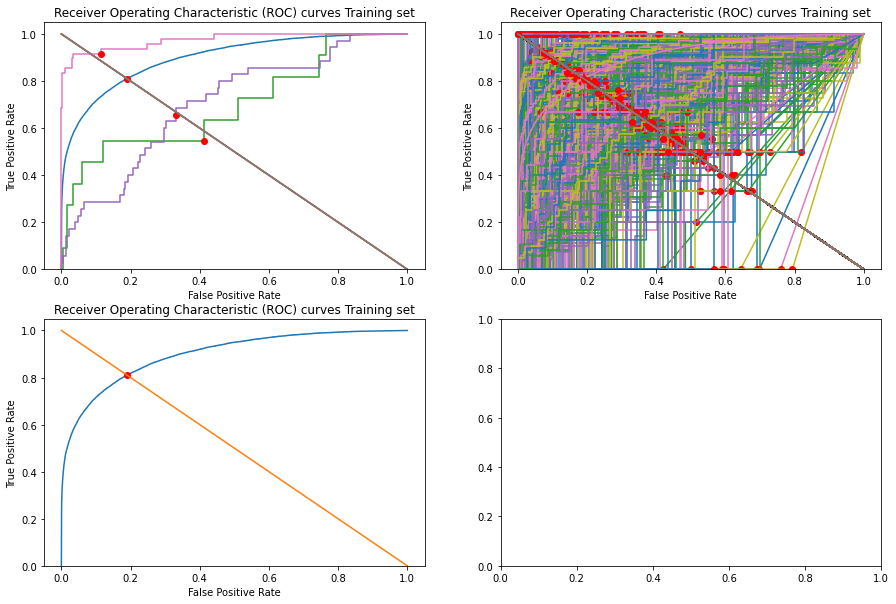

In [169]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_eer_roc(fpr['micro'], tpr['micro'], axes[0][0], result_roc['micro'], "Training set")
metrics.plot_eer_roc(fpr['micro'], tpr['micro'], axes[1][0], result_roc['micro'], "Training set")
metrics.plot_eer_roc(fpr[0], tpr[0], axes[0][0], result_roc[0], "Training set")
metrics.plot_eer_roc(fpr[1], tpr[1], axes[0][0], result_roc[1], "Training set")
metrics.plot_eer_roc(fpr[2], tpr[2], axes[0][0], result_roc[2], "Training set")
for key in result_roc.keys():
    metrics.plot_eer_roc(fpr[key], tpr[key], axes[0][1], result_roc[key], "Training set")

In [170]:
df_val_scores = dashboard_model.contruct_auc_scores_by_TF(df_val_y, df_val_score, ad)

import scipy.stats as st
print(st.norm.interval(alpha=0.99, loc=np.mean(df_val_scores['auc_pr']), scale=st.sem(df_val_scores['auc_pr'])))
percentile = 99
low_99 = round(len(df_val_scores[df_val_scores['count_regions'] > 0])*(100-percentile)/2/100)
up_99 = round(len(df_val_scores[df_val_scores['count_regions'] > 0])*(percentile + (100-percentile)/2)/100)
print('auc roc score : ', df_val_scores[df_val_scores['count_regions'] > 0]['auc_roc'][low_99:up_99+1].mean())
print('auc pr score : ', df_val_scores[df_val_scores['count_regions'] > 0]['auc_pr'][low_99:up_99+1].mean())

(0.24353242104652567, 0.2935336485503652)
auc roc score :  0.7980960670847901
auc pr score :  0.2896666565322138


In [171]:
df_val_scores_region = contruct_auc_scores_by_region(df_val_y, df_val_score, val_ids, ad)
df_val_scores_region
print('auc roc score : ', df_val_scores_region['auc_roc'].mean())
print('auc pr score : ', df_val_scores_region['auc_pr'].mean())

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


auc roc score :  0.6726709686297967
auc pr score :  0.24482689223823814


In [172]:
fig = px.scatter(df_val_scores, x="auc_roc", y="auc_pr", hover_data=['TF', 'cell_line', 'motif_model', 'count_regions'], 
                 color="TF", marginal_x="rug", marginal_y="rug")
fig.show()

In [173]:
df_val_pred = df_val_score.where(df_val_score > opt_threshold['micro'], other=0)
df_val_pred = df_val_pred.where(df_val_pred == 0, other=1)

100%|█████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.83batch/s]
/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples 

2.597432e-11


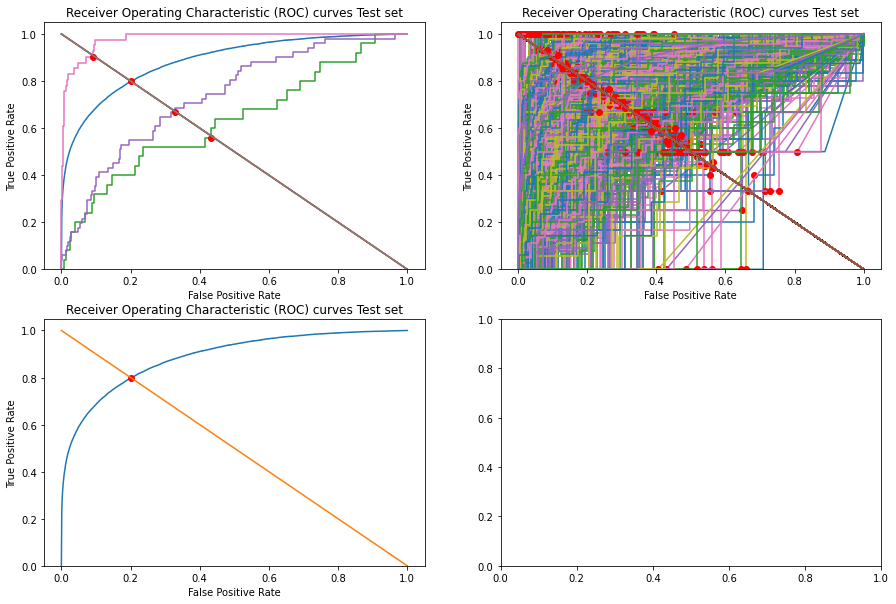

In [174]:
df_test_score, df_test_y = dashboard_model.predict_batch(dashboard_model.test_dataloader)
fpr, tpr, fnr, opt_threshold, threshold, roc_auc, result_roc = metrics.roc_curve_multilabel(df_test_score, df_test_y)

print(opt_threshold['micro'])

sum = 0
for key in opt_threshold.keys():
    if key != 'micro':
        sum += opt_threshold[key]
print(sum / (len(opt_threshold.keys()) - 1))

figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_eer_roc(fpr['micro'], tpr['micro'], axes[0][0], result_roc['micro'], "Test set")
metrics.plot_eer_roc(fpr['micro'], tpr['micro'], axes[1][0], result_roc['micro'], "Test set")
metrics.plot_eer_roc(fpr[0], tpr[0], axes[0][0], result_roc[0], "Test set")
metrics.plot_eer_roc(fpr[1], tpr[1], axes[0][0], result_roc[1], "Test set")
metrics.plot_eer_roc(fpr[2], tpr[2], axes[0][0], result_roc[2], "Test set")
for key in result_roc.keys():
    metrics.plot_eer_roc(fpr[key], tpr[key], axes[0][1], result_roc[key], "Test set")

In [175]:
df_test_scores = dashboard_model.contruct_auc_scores_by_TF(df_test_y, df_test_score, ad)
print(st.norm.interval(alpha=0.99, loc=np.mean(df_test_scores['auc_pr']), scale=st.sem(df_test_scores['auc_pr'])))

percentile = 99
low_99 = round(len(df_test_scores[df_test_scores['count_regions'] > 0])*(100-percentile)/2/100)
up_99 = round(len(df_test_scores[df_test_scores['count_regions'] > 0])*(percentile + (100-percentile)/2)/100)
print('auc roc score : ', df_test_scores[df_test_scores['count_regions'] > 0]['auc_roc'][low_99:up_99+1].mean())
print('auc pr score : ', df_test_scores[df_test_scores['count_regions'] > 0]['auc_pr'][low_99:up_99+1].mean())

(0.24734668073244379, 0.2949911808884313)
auc roc score :  0.7961019888709273
auc pr score :  0.28862168227506635


In [176]:
df_test_scores_region = contruct_auc_scores_by_region(df_test_y, df_test_score, test_ids, ad)
df_test_scores_region
print('auc roc score : ', df_test_scores_region['auc_roc'].mean())
print('auc pr score : ', df_test_scores_region['auc_pr'].mean())

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


auc roc score :  0.6809173525307864
auc pr score :  0.22121869609977163


In [177]:
colorscales = px.colors.cyclical.swatches_continuous()
fig = px.scatter(df_test_scores, x="auc_roc", y="auc_pr", hover_data=['TF', 'cell_line', 'motif_model', 'count_regions'], 
                 color="TF", marginal_x="rug", marginal_y="rug", color_discrete_sequence=px.colors.qualitative.Dark24)
fig.show()

In [178]:
df_test_scores.TF.value_counts().head(20)

CTCF     170
SPI1      46
MYC       44
RUNX1     36
GATA1     36
RXRA      28
YY1       26
RELA      24
FOS       23
CEBPA     23
CEBPB     18
JUN       14
GATA2     14
JUND      13
VDR       13
REST      12
GATA3     11
TP53      11
MAX       10
GABPA     10
Name: TF, dtype: int64

In [179]:
selection = ['CTCF', 'RELA', 'FOS', 'SPI1', 'MYC','PAX5', 'RUNX1', 'RXRA', 'E2F1', 'GATA3', 'GATA2', 'YY1', 'CEPBA', 'SPIB', 'JUN', 'FOSL1']

df2 = df_test_scores[df_test_scores.TF.apply(lambda x: np.any(np.in1d(x, selection)))]
df2.TF.cat.remove_unused_categories(inplace=True)
df2.TF.head(5)

/local_scratch/tmp-vsc34619/ipykernel_5040/3746464426.py:4: FutureWarning:

The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.



1    GATA3
2     CTCF
3     CTCF
4     CTCF
5     CTCF
Name: TF, dtype: category
Categories (15, object): ['CTCF', 'E2F1', 'FOS', 'FOSL1', ..., 'RXRA', 'SPI1', 'SPIB', 'YY1']

In [180]:
import plotly.express as px
colorscales = px.colors.cyclical.swatches_continuous()
fig = px.scatter(df2, x="auc_roc", y="auc_pr", hover_data=['TF', 'cell_line', 'motif_model', 'count_regions'], 
                 color="TF", marginal_x="rug", marginal_y="rug", color_discrete_sequence=px.colors.qualitative.Dark24)
fig.show()

In [181]:
df_test_pred = df_test_score.where(df_test_score > opt_threshold['micro'], other=0)
df_test_pred = df_test_pred.where(df_test_pred == 0, other=1)